In [18]:
from miniGPT import GPT
from gym.wrappers import TimeLimit, RecordEpisodeStatistics, NormalizeObservation, NormalizeReward, TransformObservation
import gym
import torch
import random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# func to quantize state
def binary(num, length=4):
    return [int(i) for i in list(format(num, '#0{}b'.format(length + 2)))[2:]]

# gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
max_ep_length = 2**9 # maximum number that can exists in timesteps
env = TimeLimit(env, max_episode_steps=max_ep_length)
env = TransformObservation(env, f=lambda x: binary(x, length=4))
#env = NormalizeObservation(env)
#env = NormalizeReward(env)
env = RecordEpisodeStatistics(env, deque_size=max_ep_length)
state_dim = 1 #env.observation_space.n
action_dim = env.action_space.n
print(f"state_dim: {state_dim}, action_dim: {action_dim}")


# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = 8 # which integers can exist 16 is max for observation
model_config.block_size = max_ep_length * model_config.vocab_size # sequence max size
model = GPT(model_config).to(device)
print(model_config)

optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
loss_fn = torch.nn.SmoothL1Loss()

state_dim: 1, action_dim: 4
number of parameters: 3.46M
model_type: gpt-mini
n_layer: 6
n_head: 6
n_embd: 192
vocab_size: 8
block_size: 4096
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1



In [20]:
# [s_1, a1_1, a2_1, a3_1, a4_1, s_2, a1_2, a2_2, a3_2, a4_2, ..., s_T, a1_T, a2_T, a3_T, a4_T]
max_memory = 2**5
memory = deque(maxlen=max_memory*(1 + action_dim)) # each step saves 5 elements
print(f"max_memory: {max_memory}")

losses = []
episode_rewards = []

max_memory: 32


In [21]:
observation, info = env.reset()
games = 0
epsilon = 0.8
action = [0 for _ in range(action_dim)]
while games < 2000:
    memory.extend(observation)
    memory.extend(action)

    actionIndex = 0
    action = [0 for _ in range(action_dim)]
    # agent act
    mem = torch.tensor(memory, dtype=torch.int).to(device)
    mem = mem.unsqueeze(0) # add batch dim
    logits, loss = model(mem)

    logits = logits.squeeze(0) # remove batch dim
    sequence_pred = logits[0] # get first predicted sequence
    action_preds = sequence_pred[4:] # ignore first 2 elements obs, t
    if random.random() < epsilon:
        actionIndex = env.action_space.sample()
    else:
        actionIndex = torch.argmax(action_preds).item()


    observation, reward, terminated, truncated, info = env.step(actionIndex)


    action[actionIndex] = (reward * (1 - (terminated or truncated))) # this action resulted in this reward = 0 if game is over


    next_sequence_truth = torch.tensor(observation + action, dtype=torch.int).to(device)

    
    # learn from what we predicted to what is truth
    if sequence_pred is not None:
        loss = loss_fn(sequence_pred, next_sequence_truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    epsilon = max(epsilon * 0.999, 0.01)

    # if done
    if terminated or truncated:
        #if (games % 100) == 0:
        print(f"games: {games},  epsilon: {epsilon}, episode: {info['episode']}")
        episode_rewards.append(info["episode"]["r"])
        
        games += 1

        action = [0 for _ in range(action_dim)]
        t = 1

        observation, info = env.reset()

games: 0,  epsilon: 0.7968047968008, episode: {'r': 0.0, 'l': 4, 't': 0.491086}


/home/pedron18/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


games: 1,  epsilon: 0.7880836370896016, episode: {'r': 0.0, 'l': 11, 't': 0.764292}
games: 2,  epsilon: 0.7857217496411605, episode: {'r': 0.0, 'l': 3, 't': 0.828951}
games: 3,  epsilon: 0.7825835738309924, episode: {'r': 0.0, 'l': 4, 't': 0.914714}
games: 4,  epsilon: 0.7778997955016765, episode: {'r': 0.0, 'l': 6, 't': 1.048391}
games: 5,  epsilon: 0.7716983348239579, episode: {'r': 0.0, 'l': 8, 't': 1.221211}
games: 6,  epsilon: 0.7701557098526448, episode: {'r': 0.0, 'l': 2, 't': 1.263606}
games: 7,  epsilon: 0.7655463125376102, episode: {'r': 0.0, 'l': 6, 't': 1.393184}
games: 8,  epsilon: 0.7602035380550674, episode: {'r': 0.0, 'l': 7, 't': 1.514082}
games: 9,  epsilon: 0.7526356207687559, episode: {'r': 0.0, 'l': 10, 't': 1.690986}
games: 10,  epsilon: 0.7496295910896157, episode: {'r': 0.0, 'l': 4, 't': 1.759556}
games: 11,  epsilon: 0.7436535020626244, episode: {'r': 0.0, 'l': 8, 't': 1.895032}
games: 12,  epsilon: 0.7414247717732892, episode: {'r': 0.0, 'l': 3, 't': 1.945749}

KeyboardInterrupt: 

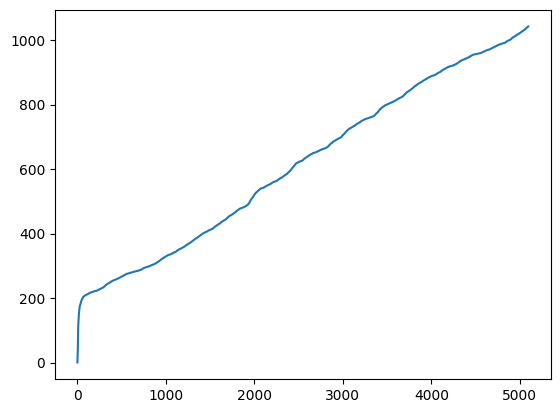

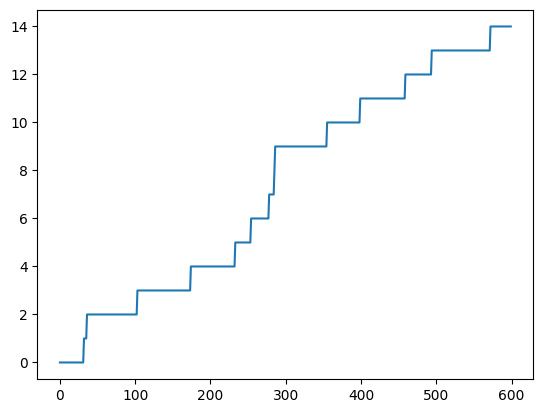

In [ ]:
memory.clear()

# plot losses
plt.plot(np.cumsum(losses))
plt.show()

plt.plot(np.cumsum(episode_rewards))
plt.show()
